In [116]:
import numpy as np
from scipy.integrate import solve_ivp, cumulative_trapezoid
from rebound import M_to_f
import matplotlib.pyplot as plt
from multiprocessing import Pool
from itertools import product

In [141]:
e = 0.1
A, B, C, = 0.32, 0.46, 0.52
# A, B, C = 0.39, 0.4, 0.41

def rot_func(t, y):
    theta, theta_dot, del_p, del_theta = y
    M = t
    f = M_to_f(e, M)
    r = (1-e**2)/(1+e*np.cos(f))
    theta_dot_dot = -1.5/r**3*(B-A)/C*np.sin(2*(theta-f))
    del_theta_dot = del_p/C
    del_p_dot = -3/r**3*(B-C)*np.cos(2*(theta-f))*del_theta
    return [theta_dot, theta_dot_dot, del_p_dot, del_theta_dot]

P = 2*np.pi
ts = np.linspace(0, 50*P, 1000)
theta0 = 0.1
theta_dot0 = 2.1
del_p0, del_theta0 = 1e-10, 1e-10
rot_sol = solve_ivp(rot_func, [ts[0], ts[-1]], [theta0, theta_dot0, del_p0, del_theta0], t_eval=ts, dense_output=True, method='Radau', rtol=1e-6, atol=1e-9)
derivs = np.array([rot_func(t, y) for t, y in zip(rot_sol.t, rot_sol.y.T)]).T

Text(0.5, 0, 't')

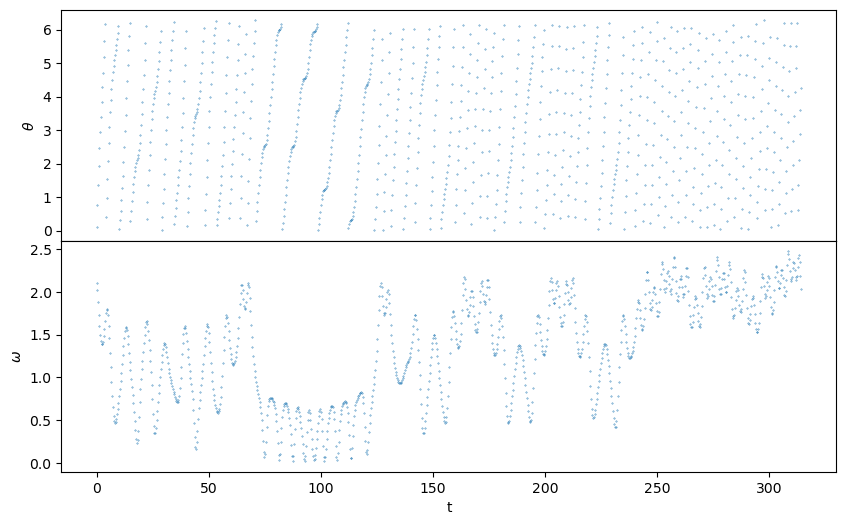

In [142]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'hspace':0})
axs[0].scatter(rot_sol.t, np.remainder(rot_sol.y[0], 2*np.pi), s=0.1)
axs[1].scatter(rot_sol.t, rot_sol.y[1], s=0.1)
axs[0].set_ylabel(r'$\theta$')
axs[1].set_ylabel(r'$\omega$')
axs[1].set_xlabel('t')

Text(0, 0.5, 'MEGNO')

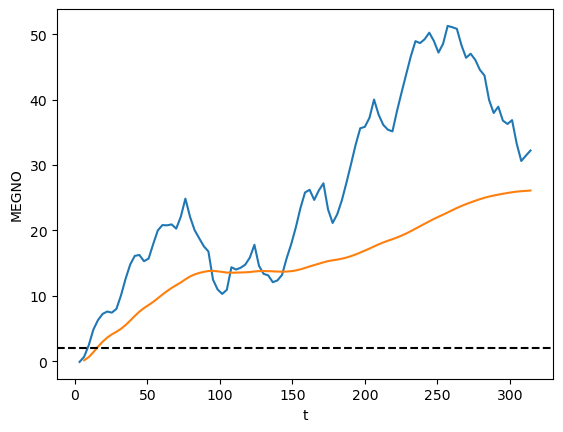

In [112]:
del_dot_over_del = (rot_sol.y[2]*derivs[2] + rot_sol.y[3]*derivs[3])/(rot_sol.y[2]**2 + rot_sol.y[3]**2)
Y = cumulative_trapezoid(del_dot_over_del*rot_sol.t, rot_sol.t)*2/rot_sol.t[1:]
Y_avg = cumulative_trapezoid(Y, rot_sol.t[1:])/rot_sol.t[2:]
plt.plot(rot_sol.t[1:], Y)
plt.plot(rot_sol.t[2:], Y_avg)
plt.axhline(2, color='k', linestyle='--')
plt.xlabel('t')
plt.ylabel(r'MEGNO')

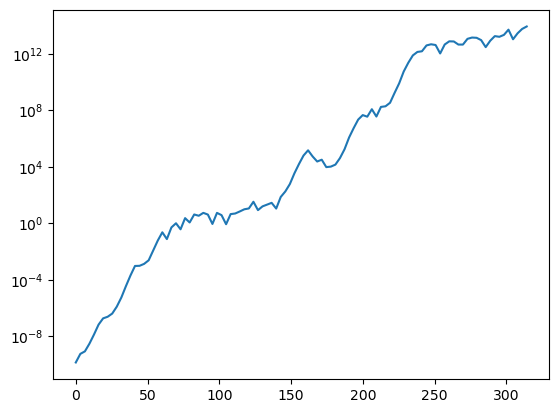

In [113]:
plt.plot(rot_sol.t, np.linalg.norm(rot_sol.y[2:], axis=0))
plt.yscale('log')

/tmp/ipykernel_1344784/3365691555.py:1: RuntimeWarning: invalid value encountered in divide
  lyap = np.log(np.sqrt(np.linalg.norm(rot_sol.y[2:], axis=0)/np.linalg.norm(rot_sol.y[2:,0])))/rot_sol.t


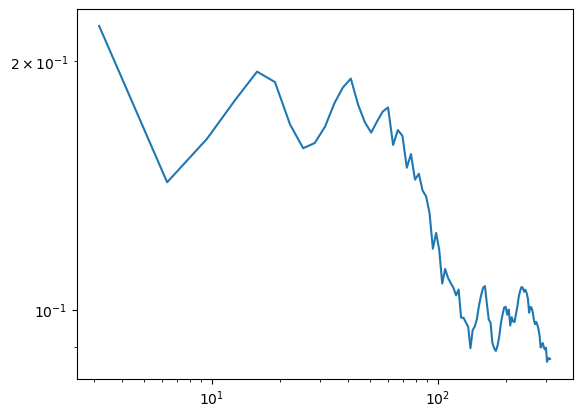

In [114]:
lyap = np.log(np.sqrt(np.linalg.norm(rot_sol.y[2:], axis=0)/np.linalg.norm(rot_sol.y[2:,0])))/rot_sol.t
plt.plot(rot_sol.t, lyap)
plt.yscale('log'); plt.xscale('log')

In [135]:
def get_MEGNO(theta0, theta_dot0, del_p0=1e-10, del_theta0 = 1e-10, t_end=50):
    ts = np.linspace(0, t_end*P, 1000)
    rot_sol = solve_ivp(rot_func, [ts[0], ts[-1]], [theta0, theta_dot0, del_p0, del_theta0], t_eval=ts, dense_output=True, method='Radau', rtol=1e-6, atol=1e-9)
    derivs = np.array([rot_func(t, y) for t, y in zip(rot_sol.t, rot_sol.y.T)]).T
    del_dot_over_del = (rot_sol.y[2]*derivs[2] + rot_sol.y[3]*derivs[3])/(rot_sol.y[2]**2 + rot_sol.y[3]**2)
    Y = cumulative_trapezoid(del_dot_over_del*rot_sol.t, rot_sol.t)*2/rot_sol.t[1:]
    Y_avg = cumulative_trapezoid(Y, rot_sol.t[1:])/rot_sol.t[2:]
    return Y_avg[-1]

theta0s = np.linspace(0, 2*np.pi, 100)
theta_dot0s = np.linspace(0, 4, 100)
inits = product(theta0s, theta_dot0s)
p = Pool(35)
MEGNOs = p.starmap(get_MEGNO, inits)


Text(0, 0.5, '$\\omega_0$')

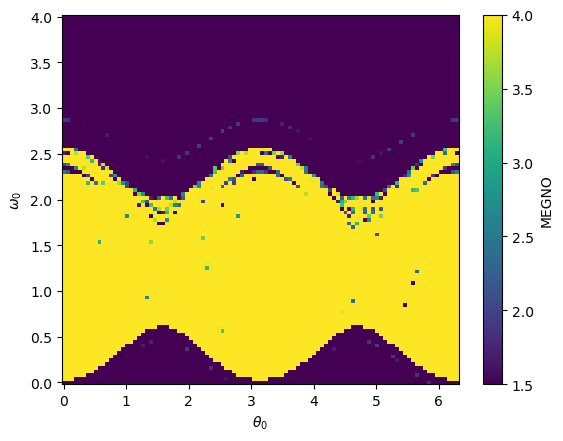

In [139]:
plt.pcolormesh(theta0s, theta_dot0s, np.array(MEGNOs).reshape(len(theta0s), len(theta_dot0s)).T, cmap='viridis', vmin=1.5, vmax=4)
plt.colorbar(label=r'MEGNO')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\omega_0$')
# plt.savefig('figs/megno_map_1d.png')